<a href="https://colab.research.google.com/github/gpostill/Applied-ML-for-Healthcare-Course-Project/blob/main/Task1_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Submission Code

**Course**: Applied Machine Learning for Health Data (CHL5230H)
**Authors**: Gemma Postill and Ijeoma Itany
**Date**: December 5th 2023

###Task 1: Predicting premature mortality from multimorbidity

In this tasks we will determing if the types of chronic conditions developed over life course reliably predict premature mortality. We will build four predictive ML models (Logistic Regression, Random Forest, and XGBoost) to determine which model best characterizes this relationship.

###Importing the Necessary Packages

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder #TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#removing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


Mounted at /content/drive


###Defining Functions for Model

We define the following functions
- model_pipeline() - Creates a model pipeline
- hyp_tuning() - Tunes the model given specified ranges of hyperparameters
- eval_model() - Creates a classification report and confusion matrix of model
- auc_model() - Determines AUC for training and testing & plots both on a graph
- feature_importance() - Identifies the salient features of model

In [ ]:
def model_pipeline():
    """
    Parameters
    ----------
    categorical_columns : LIST of categorical columns (using OneHotEncoder)
    high_level_columns : LIST of columns iwth many categorys (using TargetEncoder)
    initialized_model : MODEL (already initialized)

    Returns
    ---------
    model : returns a Pipeline
      Includes the transformation of columns and the model

    NOTE: in Task 1, we forego the pipeline because we are not pre-processing the data (already in a binary, pre-encoded state)

    """

    #Initializing a column transformer that will handle categorical data encoding
      #OneHot Encoding is applied to the categorical columns specified in the list 'categorical_colums'
      #TargetEncoding is applied to the other columns

    ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [c for c in categorical_columns]),
    ('target_encoder', TargetEncoder(), high_level_columns)], remainder='passthrough')

    #Creating a pipeline:
      #First, the data goes through the specified column transformations (ct)
      #Then the transformed dta is used to train or predict using the gradient boosting model

    model = Pipeline([('pre_process', ct),
     ('model', initialized_model)])

    #Displaying the pipeline architecture
    model

    return model


def hyp_tuning(MODEL_NAME, model, param_dict, skf, X_train, y_train):
  """
  Parameters
  ---------
  MODEL_NAME : STRING - model type
  model : MODEL - SKLearn Model pretrained
  param_dict :  DICTIONARY - dictionary of the parameters values to be tested
  skf : Stratified K Fold of data

  Returns
  ---------
  retrained_model : MODEL - retrained with optimal hyperparameters
  best_params :

  """

  #Setting up the GridSearchcCV to find the best hyperparameters for the Gradient Boosting Model
  grid_search = GridSearchCV(model, param_grid=param_dict, cv=skf)

  #Fitting the GridSearchCV on the training data
  grid_search.fit(X_train, y_train)

  #Updating the model's parameters with the best ones found from GridSearchCV
  best_model = grid_search.best_estimator_

  #Retraining the model with the best parameters on the training dataset
  retrained_model = best_model.fit(X_train, y_train)

  #Print the parameters of the best model:
  best_params = retrained_model.get_params()
  print(MODEL_NAME+" Best Model Parameters")
  print(best_params)

  return retrained_model, best_params


def eval_model(model_name, y_test, Y_pred):
  """
  Parameters
  ----------
  model_name : STRING - name of model type


  Returns
  ----------
  conf_matrix : Confusion Matriz of Model Performance
  class_report : Classification Report

  """

  #Confusion Matrix
  print(model_name+" Confusion Matrix")
  conf_matrix = confusion_matrix(y_test, Y_pred)
  print(conf_matrix)

  #Classification Report
  print(model_name+" Classification Report")
  class_report = classification_report(y_test, Y_pred)
  print(class_report)

  return conf_matrix, class_report


def auc_model(retrained_model, X_train, y_train, X_test, y_test, plot_name):
  """
  Parameters
  -----------
  retrained_model : MODEL
  plot_name : STRING of the pathway for saving plot

  """

  #Predicting on the trainign dataset and computing the accuracy
  y_pred_train = retrained_model.predict(X_train)
  accuracy_score_retrain = accuracy_score(y_train, y_pred_train) #Gets the accuracy score
  fpr_train, tpr_train, thresholds_train = roc_curve(y_pred_train, y_train) #Gets the true positive and false positive rates of teh model compared to the label
  roc_auc_train = auc(fpr_train, tpr_train)

  print("The accuracy of the optimized model on the training data: ")
  print(accuracy_score_retrain)

  #Predicting on the test set
  Y_pred_test = retrained_model.predict(X_test)
  accuracy_score_test = accuracy_score(y_test, Y_pred_test) #Gets the accuracy score
  fpr_test, tpr_test, thresholds_test = roc_curve(Y_pred_test, y_test) #Gets the true positive and false positive rates of the model compared to the label
  roc_auc_test = auc(fpr_test, tpr_test)

  print("The accuracy of the optimized model on the testing data: ")
  print(accuracy_score_test)

  #Plotting the ROC Curve
  plt.figure(figsize=(8,8))
  plt.plot(fpr_train, tpr_train, color='dodgerblue', lw=2, label="Train AUC = {:.2f}".format(roc_auc_train))
  plt.plot(fpr_test, tpr_test, color='navy', lw=2, label="Test AUC = {:.2f}".format(roc_auc_test))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.savefig(plot_name)
  plt.show()

  return accuracy_score_retrain, accuracy_score_test


def feature_importance(model, plt_name):
  """
  Parameters
  ----------
  model : SKLearn MODEL, retrained
  plt_name : STR of location where png will be saved

  Returns
  ----------
  feature_imp : weights of important features of model

  """
  feature_imp = model.feature_importances_

  #Get the names of the features
  feature_names = X_train.columns

  #Sort features based on their importance
  sorted_indices = np.argsort(feature_imp)

  #plot the feature importances
  plt.figure(figsize=(10,6))
  bars = plt.bar(range(len(feature_imp)), feature_imp[sorted_indices], color='navy')
  plt.xticks(range(len(feature_imp)), np.array(feature_names)[sorted_indices], rotation=70)

  for bar, importance in zip(bars, feature_imp[sorted_indices]):
    plt.text(bar.get_x()+ bar.get_width() / 2 - 0.15, bar.get_height() + 0.005, '{:.2f}'.format(importance), ha='center', va='bottom')

  plt.savefig(plt_name)
  plt.show()

  return feature_imp




### Importing the Data

In [ ]:
#Reading the csv of the file created in the prior desriptive analysis (Not regenerating Dummy data for consistency)
data = pd.read_csv("drive/My Drive/CHL5320_Course_Project/DummyData.csv") #Gemma

#Copying the original dataframe and selecting the columns included in the prediction
df = data.copy()

#df.columns

#Subsetting to the relevant columns (only binary yes/no of conditions and sex)
df = df[['Premature', 'sex', 'Asthma', 'CHF', 'COPD', 'Myocardial_infarction', 'Hypertension', 'Arrythmia', 'CCS', 'Stroke', 'Cancer', 'Dementia',
         'Rental_disease', 'Diabetes', 'Osteoporosis', 'Rheumatoid_Arthritis', 'Oseo_Arthritis', 'Mood_disorder', 'Other_Mental_disorder']]

#Encoding the categorical variables
df = df.replace({"No": 0, "Yes": 1})
df - df.replace({"M": 0, "F": 1})

print("The number of patients included in the model: ")
print(len(df))

#Display dataframe
df.head()

The number of patients included in the model: 
300


,Premature,sex,Asthma,CHF,COPD,Myocardial_infarction,Hypertension,Arrythmia,CCS,Stroke,Cancer,Dementia,Rental_disease,Diabetes,Osteoporosis,Rheumatoid_Arthritis,Oseo_Arthritis,Mood_disorder,Other_Mental_disorder
0,1,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0,1,0,0
1,1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,0,1,1,0
2,1,0,1,0,1,1,0,0,0,1,0,0,1,1,1,0,0,1,0
3,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1


###Splitting the Data 80:20 & Creating Cross Folds

Note - we would typical scale the training data after splitting; however, we have foregon this step because the dataset used is binary 0/1

In [ ]:
#Removing the label from dataset
X = df.drop('Premature', axis=1) #The label is premature death (0/1)
y = df['Premature']

#Splitting the data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

#Initializing stratified
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)


###Logistic Regression

In [ ]:
#Developing Model

#Initializing the LR Model
LR_model = LogisticRegression(penalty="l2", C=1.0, solver='liblinear')
#NOTE: in this task, we forego the pipeline because we are not pre-processing the data (already preprocessed)

#Training the model model on the training data
trained_LR_model = LR_model.fit(X_train, y_train)

#Predicting on the training data and computing the acccuracy
Y_pred_LR = trained_LR_model.predict(X_test)
accuracy_og_LR = accuracy_score(y_test, Y_pred_LR)
print("Accuracy score of the original Logistic Regression model:")
print(accuracy_og_LR)

#Assessing the accuracy across the folds - prior to optimization of parameters
cv_LR_results = cross_val_score(trained_LR_model, X_train, y_train, cv=skf, scoring='accuracy')



0.65


In [ ]:
#Hyperparameter Tuning

#Defining the hyperparameters to be tuned using GridSearchCV
param_dict_LR = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                 "penalty" : ["l1", "l2", "elasticnet", "none"],
                 "solver" : ["liblinear", "newton-cg", "sag"]}

#Using the function to tune hyperparameters and retrain model
retrained_LR_model, LR_params = hyp_tuning("Logisitic Regression", trained_LR_model, param_dict_LR, skf, X_train, y_train)


Logisitic Regression Best Model Parameters
{'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


The accuracy score of the original Logistic Regression model: 
0.75
Cross Validation Accuracy Scores of Optimized Logistic Regression Model: 
[0.71666667 0.71666667 0.7        0.7        0.7       ]
Logisitc Regression Confusion Matrix
[[ 0 15]
 [ 0 45]]
Logisitc Regression Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.75      1.00      0.86        45

    accuracy                           0.75        60
   macro avg       0.38      0.50      0.43        60
weighted avg       0.56      0.75      0.64        60

The accuracy of the optimized model on the training data: 
0.6958333333333333
The accuracy of the optimized model on the testing data: 
0.75


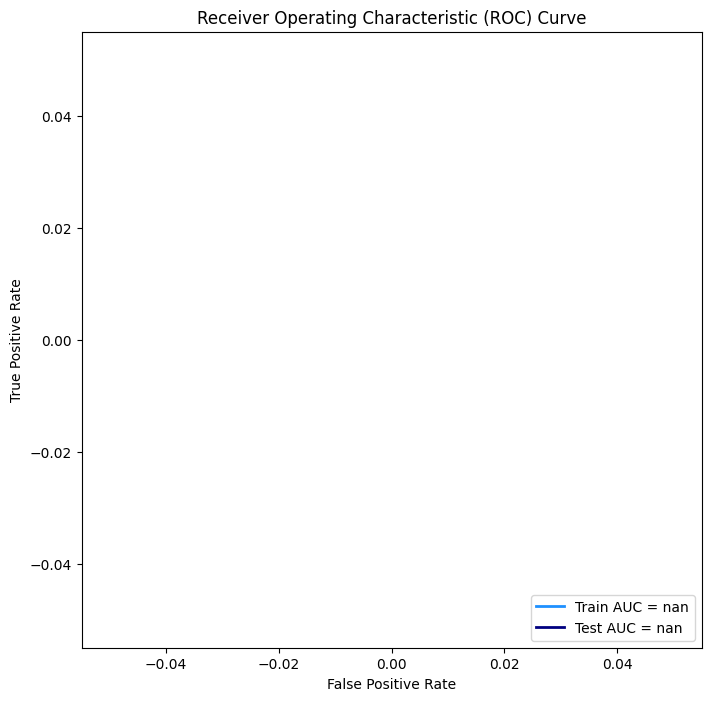

Log-Loss of Final Logisitc Regression Model: 
0.6505298731015489


In [ ]:
#Evaluating Model

#Retrained Model Accuracy
Y_pred_LR = retrained_LR_model.predict(X_test)
accuracy_LR = accuracy_score(y_test, Y_pred_LR)
print("The accuracy score of the original Logistic Regression model: ")
print(accuracy_LR)

#Assessing accuracy across the folds
cv_LR_results = cross_val_score(retrained_LR_model, X_train, y_train, cv=skf, scoring='accuracy')
print("Cross Validation Accuracy Scores of Optimized Logistic Regression Model: ")
print(cv_LR_results)

#Confusion Matrix and Classification Report
LR_conf_matrix, LR_class_report = eval_model("Logisitc Regression", y_test, Y_pred_LR)

#Accuracy + AUC plot with the new retrained model
acc_train_LR, acc_test_LR = auc_model(retrained_LR_model, X_train, y_train, X_test, y_test, 'Task1_AUC_LR.png')

#Measuring the log-loss of the model
#Log-Loss measures how well the predicted probabilities match the true distribution of the class
#Log Loss between 0-1 indicates teh model is performing reasonably well (not overfitting)
y_prob_LR = retrained_LR_model.predict_proba(X_test)
logloss = log_loss(y_test, y_prob_LR)
print("Log-Loss of Final Logisitc Regression Model: ")
print(logloss)


In [ ]:
#Feature Importance

#Identifying the ocefficients and corresponding feature names (column names)
coefficients = retrained_LR_model.coef_[0]
feature_names = X.columns

#Creating a corted DF of feature coefficients
feature_imp_LR = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

#Adding another column of absolute coefficients & sorting on this (magnitude of strength with predicting premature mortality)
feature_imp_LR['Absolute Coefficient'] = feature_imp_LR['Coefficient'].abs()
feature_imp_LR = feature_imp_LR.sort_values(by='Absolute Coefficient', ascending=False)

#Get the names of the features
feature_imp_LR.to_csv('Task1_Coefficients_LR.csv')

#Print Freature importance
print(feature_imp_LR)

                  Feature  Coefficient  Absolute Coefficient
16          Mood_disorder     0.023861              0.023861
10               Dementia     0.023671              0.023671
8                  Stroke     0.021252              0.021252
0                     sex     0.021199              0.021199
6               Arrythmia     0.019979              0.019979
3                    COPD     0.019946              0.019946
11         Rental_disease     0.017603              0.017603
12               Diabetes     0.016828              0.016828
1                  Asthma     0.015990              0.015990
5            Hypertension     0.015654              0.015654
14   Rheumatoid_Arthritis     0.015152              0.015152
7                     CCS     0.014355              0.014355
4   Myocardial_infarction     0.013797              0.013797
9                  Cancer     0.013506              0.013506
2                     CHF     0.012814              0.012814
15         Oseo_Arthriti

###Random Forest

In [ ]:
#Developing Model

#Initializing the RF Model
RF_model = RandomForestClassifier()
#NOTE: in this task, we forego the pipeline because we are not pre-processing the data (already preprocessed)

#Training the model model on the training data
trained_RF_model = RF_model.fit(X_train, y_train)

#Predicting on the training data and computing the acccuracy
Y_pred_RF = trained_LR_model.predict(X_test)
accuracy_og_RF = accuracy_score(y_test, Y_pred_RF)
print("The accuracy of the original random forest model: ")
print(accuracy_og_RF)

#Assessing the accuracy across the folds - prior to optimization of parameters
cv_RF_results = cross_val_score(trained_RF_model, X_train, y_train, cv=skf, scoring='accuracy')

The accuracy of the original random forest model: 
0.65


In [ ]:
#Hyperparameter Tuning

#Defining the hyperparameters to be tuned using GridSearchCV
param_dict_RF = {"n_estimators" : [50, 100, 200, 500],
                 "max_depth" : [5, 10, 15, 18],
                 "min_samples_leaf" : [5, 15, 35, 50],
                 "min_samples_split" : [2, 5, 10, 20],
                 "bootstrap" : [True, False]}

#Using the function to tune hyperparameters and retrain model
retrained_RF_model, RF_params = hyp_tuning("Random Forest", trained_RF_model, param_dict_RF, skf, X_train, y_train)


Random Forest Best Model Parameters
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 15, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


The accuracy score of the original Random Forest model: 
0.75
Cross Validation Accuracy Scores of Optimized Random Forest Model: 
[0.71666667 0.71666667 0.7        0.7        0.7       ]
Random Forest Confusion Matrix
[[ 0 15]
 [ 0 45]]
Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.75      1.00      0.86        45

    accuracy                           0.75        60
   macro avg       0.38      0.50      0.43        60
weighted avg       0.56      0.75      0.64        60

The accuracy of the optimized model on the training data: 
0.7166666666666667
The accuracy of the optimized model on the testing data: 
0.75


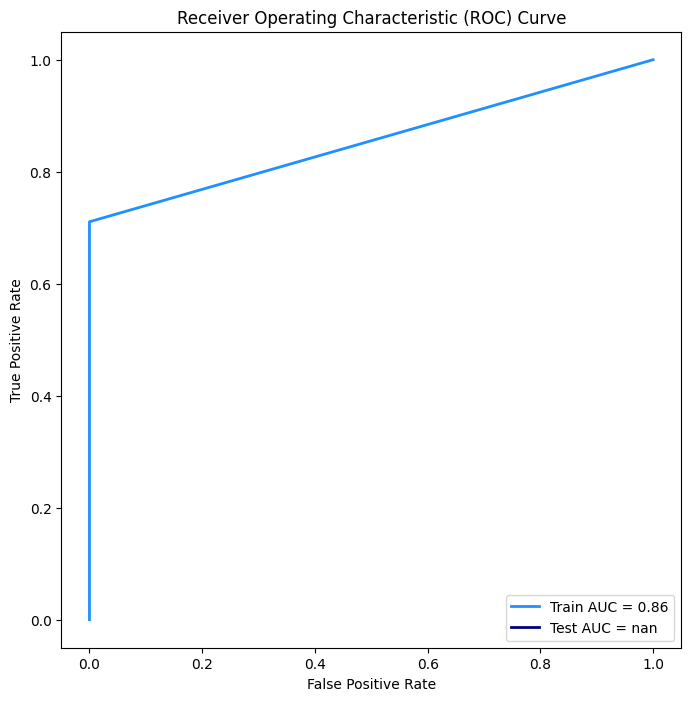

In [ ]:
#Evaluating Model

#Retrained Model Accuracy
Y_pred_RF = retrained_RF_model.predict(X_test)
accuracy_RF = accuracy_score(y_test, Y_pred_RF)
print("The accuracy score of the original Random Forest model: ")
print(accuracy_RF)

#Assessing accuracy across the folds
cv_RF_results = cross_val_score(retrained_RF_model, X_train, y_train, cv=skf, scoring='accuracy')
print("Cross Validation Accuracy Scores of Optimized Random Forest Model: ")
print(cv_RF_results)

#Confusion Matrix and Classification Report
RF_conf_matrix, RF_class_report = eval_model("Random Forest", y_test, Y_pred_RF)

#Accuracy + AUC plot with the new retrained model
acc_train_RF, acc_test_RF = auc_model(retrained_RF_model, X_train, y_train, X_test, y_test, 'Task1_AUC_RF.png')


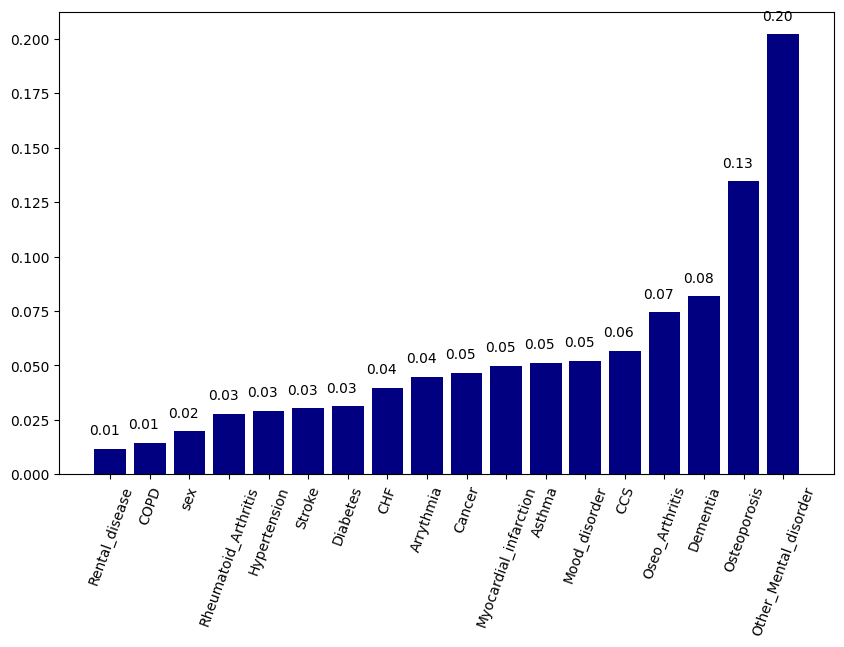

[0.01995553 0.05129818 0.0398175  0.01447248 0.04991554 0.02929257
 0.04486844 0.05676587 0.03045598 0.04676742 0.08180807 0.01185943
 0.03126782 0.1348242  0.02790433 0.07434017 0.05226165 0.20212483]


In [ ]:
#Feature Importance

#Determining the size of the final forest
RF_forest_size = len(retrained_RF_model.estimators_)

#Feature importance of the final RF model
feature_imp_RF = feature_importance(retrained_RF_model, 'Task1_feature_imp_RF.png')

#Visualizing the Tree Structure
#Seleting a tree of high feature importance to visualize (vs. a random tree from the forest)
tree_index = np.argmax(feature_imp_RF) #Getting index of important tree
selected_tree = retrained_RF_model.estimators_[tree_index] #Seleting the tree
tree_rules = tree.export_text(selected_tree, feature_names=list(X.columns))
#Exporting the tree
tree_lines = tree_rules.split('\n')
df_tree = pd.DataFrame({'Tree': tree_lines}) #Converting the tree to a dataframe
df_tree.to_csv('Task1_Visualizing_RF_tree.csv')
df_tree

#Print Freature importance
print(feature_imp_RF)

###XGBoost

In [ ]:
#Developing Model

#Initializing the RF Model
xgb_classifier = xgb.XGBClassifier()
#NOTE: in this task, we forego the pipeline because we are not pre-processing the data (already preprocessed)

#Training the model model on the training data
model_xgb = xgb_classifier.fit(X_train, y_train)

#Predicting on the training data and computing the acccuracy
Y_pred_xgb = model_xgb.predict(X_test)
accuracy_og_XGB = accuracy_score(y_test, Y_pred_xgb)
print("Accuracy of the original XGB model: " + str(accuracy_og_XGB))

#Assessing the accuracy across the folds - prior to optimization of parameters
cv_XGB_results = cross_val_score(model_xgb, X, y, cv=skf, scoring='accuracy')

Accuracy of the original XGB model: 0.5833333333333334


In [ ]:
#Hyperparameter Tuning

#Defining the hyperparameters to be tuned using GridSearchCV
param_dict_XGB = {"learning_rate" : [0.01, 0.1, 0.2],     #Controls the contribution of each weak learner
                 "n_estimators" : [50, 100, 200],         #Number of boosting stages to be run
                 "max_depth" : [1, 10, 15],                  #Controls the depth of each tree in the ensemble
                 "min_child_weight" : [1, 3]}             #Controls the minimum sum of instance weights (hessian) needed in a child (help prevent over fitting)
                #"subsample" : [0.8, 0.9, 1.0],           #Fraction of samples used for training each tree (prevents overfitting by introducing randomness)
                #"gamma" : [0, 0.1, 0.2],                 #Minimum loss reduction required to make a further partition on a leaf node
                #"reg_lambda" : [1, 2, 3],                #L2 regularization (helps prevent overfitting)
                #"reg_alpha" : [0, 0.1, 0.5]}             #L1 regulaization (helps prevent overfitting)

#Using the function to tune hyperparameters and retrain model
retrained_XGB_model, RF_params = hyp_tuning("XGBoost", model_xgb, param_dict_XGB, skf, X_train, y_train)

Random Forest Best Model Parameters
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 50, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


The accuracy score of the original XGBoost Model: 
0.7333333333333333
Cross Validation Accuracy Scores of XGBoost Model: 
[0.71666667 0.71666667 0.7        0.7        0.7       ]
XGBoost Model Confusion Matrix
[[ 0 15]
 [ 1 44]]
XGBoost Model Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.75      0.98      0.85        45

    accuracy                           0.73        60
   macro avg       0.37      0.49      0.42        60
weighted avg       0.56      0.73      0.63        60

The accuracy of the optimized model on the training data: 
0.7416666666666667
The accuracy of the optimized model on the testing data: 
0.7333333333333333


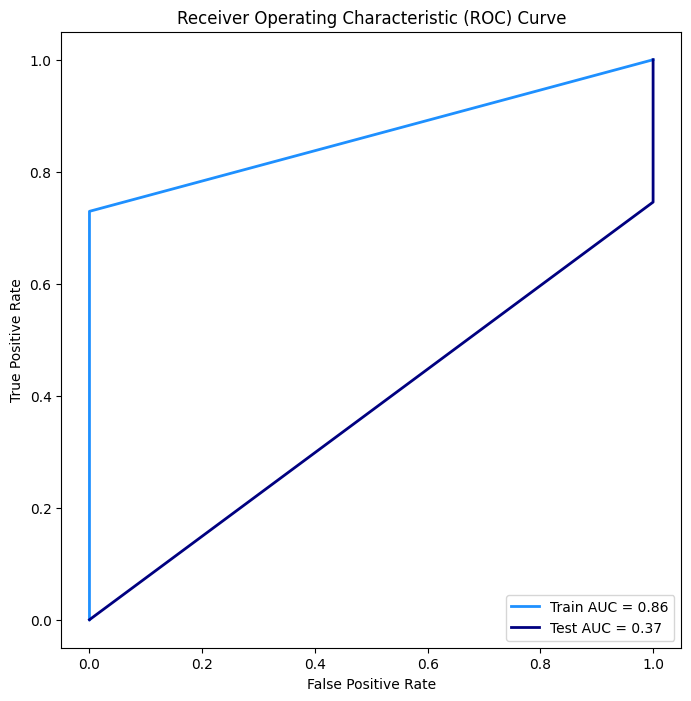

In [ ]:
#Evaluating Model

#Retrained Model Accuracy
Y_pred_XGB = retrained_XGB_model.predict(X_test)
accuracy_XGB = accuracy_score(y_test, Y_pred_XGB)
print("The accuracy score of the original XGBoost Model: ")
print(accuracy_XGB)

#Assessing accuracy across the folds
cv_XGB_results = cross_val_score(retrained_XGB_model, X, y, cv=skf, scoring='accuracy')
print("Cross Validation Accuracy Scores of XGBoost Model: ")
print(cv_XGB_results)

#Confusion Matrix and Classification Report
XGB_conf_matrix, XGB_class_report = eval_model("XGBoost Model", y_test, Y_pred_XGB)

#Accuracy + AUC plot with the new retrained model
acc_train_XGB, acc_test_XGB = auc_model(retrained_XGB_model, X_train, y_train, X_test, y_test, 'Task1_AUC_XGB.png')


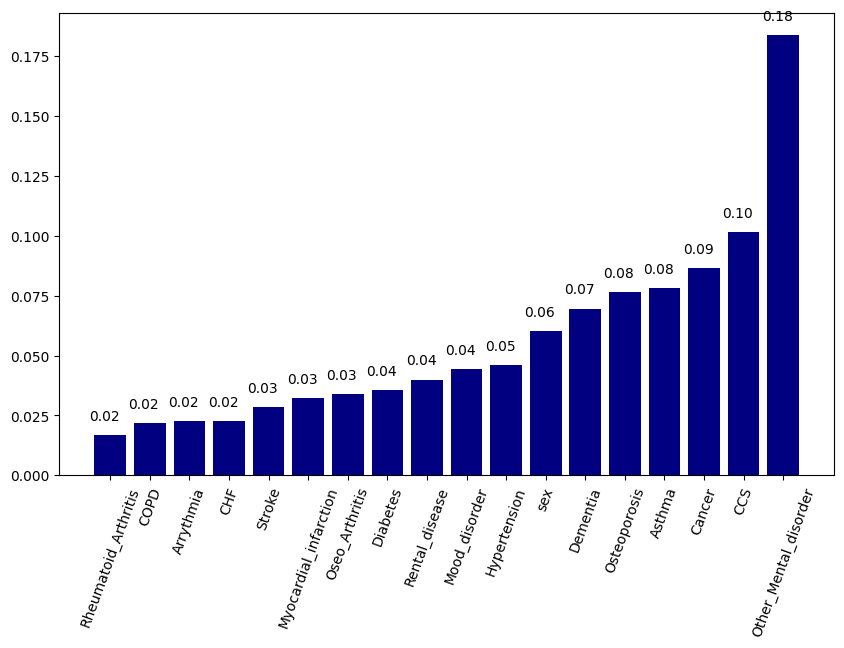

[0.06025396 0.07800885 0.0227432  0.0216922  0.03215374 0.04602167
 0.02270668 0.10148556 0.0284372  0.08635794 0.06953085 0.03998338
 0.03545615 0.07656335 0.01674681 0.03396821 0.04423636 0.18365382]


In [ ]:
#Feature Importance of Final XGB Model
feature_imp_XGB = feature_importance(retrained_XGB_model, 'Task1_feature_imp.png')
print(feature_imp_XGB)
